# **CRISP-DM — Portfolio & Long-Lived Series (PS3→PS4→PS5)**

## Step 1: Business Understanding

### Problem
We want to understand how game and sequel performance changes across PlayStation console generations and which publishers are the most stable over time, using the `PlayStationSales.csv` dataset.

### Main Questions
- **Q1**: Do sequels grow or decline when they move between `PS3`, `PS4` and `PS5`?
- **Q2**: Which publishers show stable results across multiple years and consoles?

### Objectives
- **O1**: Build a **Series Performance Index** using `Total Sales`, normalized inside each `Console × Year`.
- **O2**: Measure **sequel delta** (Part `N+1` − Part `N`) and the **generation jump effect** (for example `PS3 → PS4`, `PS4 → PS5`).
- **O3**: Rank publishers by **stability** (high median performance, low variance over time).

### Success Criteria
- At least `10` series with `3+` entries analysed.
- Top `10` publishers ranked by stability (high median, low spread).
- At least `5` clear visuals that support the conclusions.

### Scope
**In:**
- Games from consoles in the `Console` column (mainly `PS3`, `PS4`, `PS5`).
- Fields Name, Publisher, Developer, Release Date, Total Sales and regional sales (NA Sales, PAL Sales, Japan Sales, Other Sales).
- Series / franchise and part number derived from `Name` and `Release Date`.

**Out:**
- Exact unit forecasts or causal claims.
- Platforms outside the PlayStation family.

### Data
- Game title: `Name`
- Console / generation: `Console`
- Publisher: `Publisher`
- Developer: `Developer`
- Release date and year: `Release Date` → `Year`
- Performance: `Total Sales` and regional sales columns
- Extra metadata (genres, modes, etc.) if needed for context


## Step 2: Data Understanding

### What we do here
- Load `PlayStationSales.csv`.
- Parse `Release Date` into a new `Year` column.
- Use the `Console`, `Publisher`, `Total Sales` and regional sales columns.
- Build quick views to understand basic structure and distributions.

### Key views
- Releases by console and year  
  Line chart: `Year` on X, number of games on Y, separate lines for each value in `Console` (for example `PS3`, `PS4`, `PS5`).
- Total sales by year  
  Line chart: `Year` on X, sum of `Total Sales` on Y.
- Top publishers by activity  
  Horizontal bar chart: top publishers by total `Total Sales` or by number of games.

### Notes
- Rows with missing `Release Date` (and so missing `Year`) are removed.
- The focus is on PlayStation consoles in the `Console` column (mainly `PS3`, `PS4`, `PS5`).
- Data after 2018 has very low or zero `Total Sales`, so later analysis may focus on years where sales data is complete.
- This step is only about structure and distributions, not yet about the Series Performance Index or sequel analysis.


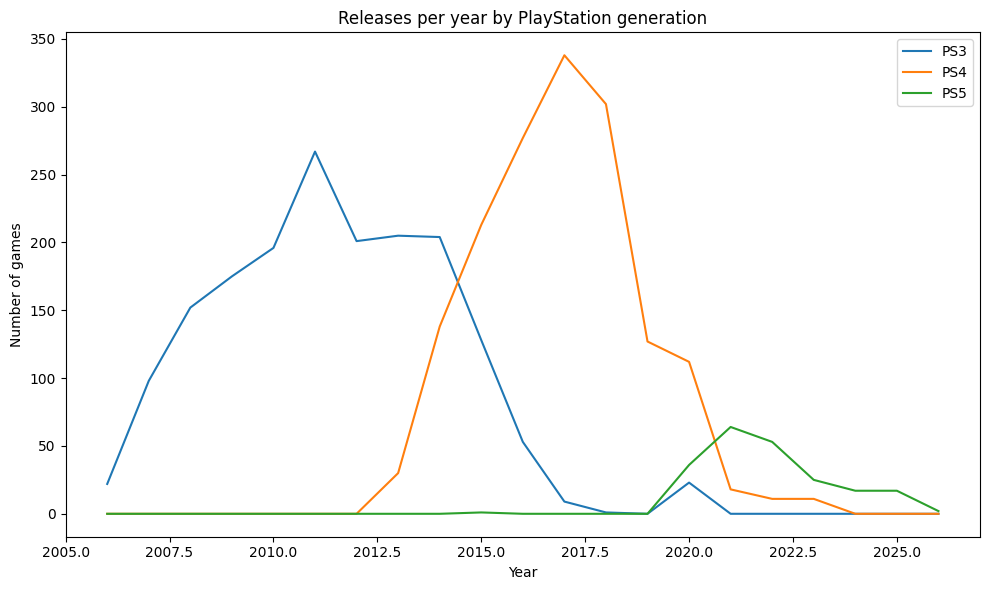

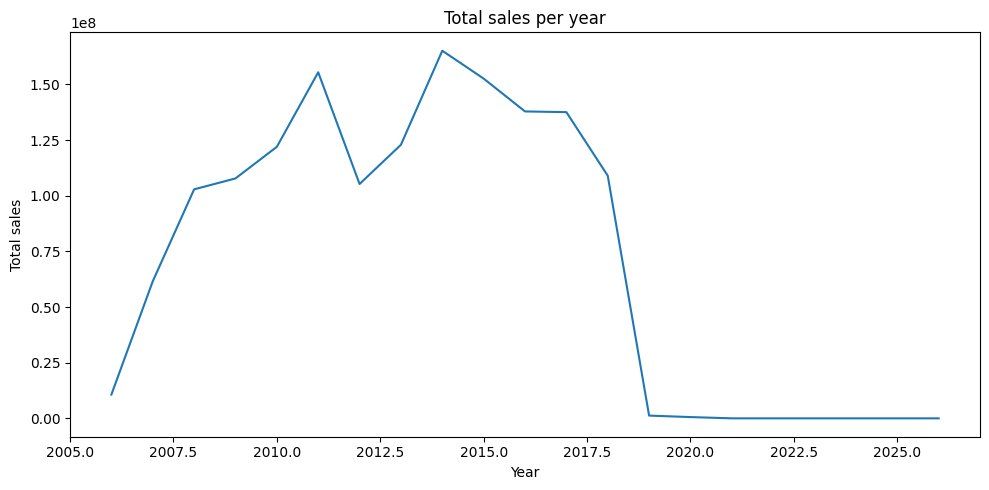

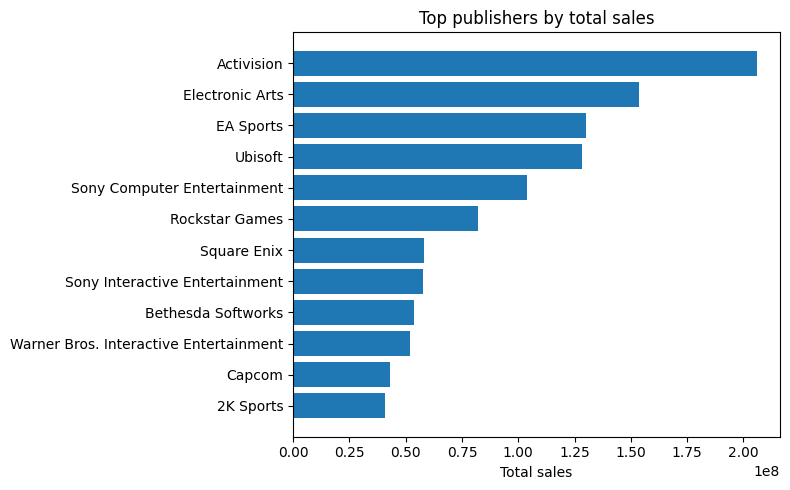

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('PlayStationSales.csv')

df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release Date'].dt.year
df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)

df['Console'] = df['Console'].astype(str)

rel = df.pivot_table(
    index='Year',
    columns='Console',
    values='Game',
    aggfunc='count'
).fillna(0).sort_index()

plt.figure(figsize=(10, 6))
for c in rel.columns:
    plt.plot(rel.index, rel[c], label=c)

plt.xlabel('Year')
plt.ylabel('Number of games')
plt.title('Releases per year by PlayStation generation')
plt.legend()
plt.tight_layout()
plt.show()

if 'Total Sales' in df.columns:
    sales_per_year = df.groupby('Year')['Total Sales'].sum().reset_index(name='TotalSales')

    plt.figure(figsize=(10, 5))
    plt.plot(sales_per_year['Year'], sales_per_year['TotalSales'])
    plt.xlabel('Year')
    plt.ylabel('Total sales')
    plt.title('Total sales per year')
    plt.tight_layout()
    plt.show()

top_pub = df.groupby('Publisher')['Total Sales'].sum().sort_values(ascending=False).head(12)

plt.figure(figsize=(8, 5))
plt.barh(top_pub.index[::-1], top_pub.values[::-1])
plt.xlabel('Total sales')
plt.title('Top publishers by total sales')
plt.tight_layout()
plt.show()


## Step 3: Data Preparation

### Parse dates
  - Convert `Release Date` to a proper date type.  
  - Create a numeric `Year` column from `Release Date`.

### Filter the usable time window  
  - Keep only years where sales data is reliable (for example `2006–2018`, because after 2018 `Total Sales` is often zero or missing).  

### Handle missing values  
  - Drop rows with missing `Release Date` or `Total Sales` if they cannot be used.  
  - Replace missing `Publisher` or `Developer` with `"Unknown"` or remove if needed.

### Focus on PlayStation generations  
  - Use only rows where `Console` is one of `PS3`, `PS4`, `PS5`.  
  - Optionally remove very rare or test entries.

### Build analytic features  
  - Create a `Series` or `Franchise` column from `Name` (group games that belong to the same series).  
  - Create a `Part` or `SequelOrder` column using `Name` and `Year` (Part 1, Part 2, etc.).  
  - Compute a **Series Performance Index** using `Total Sales`, normalized inside each `Console × Year` (for example z-score or percentile).

### Prepare data for later steps  
  - Create clean tables that we will reuse for:
    - sequel delta analysis (Part `N+1` vs Part `N`),  
    - generation jumps (`PS3 → PS4`, `PS4 → PS5`),  
    - publisher stability over time.

### Notes
- This step is about **cleaning and structuring** the data, not about building models yet.
- All strong assumptions (how we define series or part numbers) will be written clearly, so results can be interpreted correctly.


In [30]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv('PlayStationSales.csv')

df = df_raw.copy()
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release Date'].dt.year

df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)

df = df[(df['Year'] >= 2006) & (df['Year'] <= 2018)]
df = df[df['Console'].isin(['PS3', 'PS4', 'PS5'])]

df['Publisher'] = df['Publisher'].fillna('Unknown')
df['TotalSales'] = df['Total Sales'].astype(float)

def extract_series(name):
    if not isinstance(name, str):
        return 'Unknown'
    base = name
    if ':' in base:
        base = base.split(':', 1)[0]
    if '-' in base:
        base = base.split('-', 1)[0]
    return base.strip()

df['Series'] = df['Name'].apply(extract_series)

df = df.sort_values(['Series', 'Year', 'Name'])
df['SequelOrder'] = df.groupby('Series')['Year'].rank(method='first').astype(int)

group_stats = df.groupby(['Console', 'Year'])['TotalSales'].agg(['mean', 'std']).reset_index()
group_stats = group_stats.rename(columns={'mean': 'mean_sales', 'std': 'std_sales'})
df = df.merge(group_stats, on=['Console', 'Year'], how='left')

def perf_index(row):
    if pd.isna(row['std_sales']) or row['std_sales'] == 0:
        return 0.0
    return (row['TotalSales'] - row['mean_sales']) / row['std_sales']

df['PerformanceIndex'] = df.apply(perf_index, axis=1)

prep_cols = ['Game', 'Name', 'Series', 'SequelOrder',
             'Console', 'Year', 'Publisher', 'TotalSales', 'PerformanceIndex']
df_prepared = df[prep_cols]

print(df_prepared.head())


                                    Game                               Name  \
0                    PS4_#killallzombies                    #killallzombies   
1  PS3_.hack: Sekai no Mukou ni + Versus  .hack: Sekai no Mukou ni + Versus   
2            PS4_.hack//G.U. Last Recode            .hack//G.U. Last Recode   
3             PS3_007: Quantum of Solace             007: Quantum of Solace   
4                        PS3_007 Legends                        007 Legends   

                    Series  SequelOrder Console  Year           Publisher  \
0          #killallzombies            1     PS4  2015         Beatshapers   
1                    .hack            1     PS3  2012  Namco Bandai Games   
2  .hack//G.U. Last Recode            1     PS4  2017  Namco Bandai Games   
3                      007            1     PS3  2008          Activision   
4              007 Legends            1     PS3  2012          Activision   

   TotalSales  PerformanceIndex  
0         0.0         -0.376